# Base Model

Blog: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

Source code: https://github.com/hlamba28/Automatic-Image-Captioning

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(0, os.path.abspath('../scripts'))

import pickle
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from helper import *

Using TensorFlow backend.


In [2]:
FLICKR8K_TEXT = '../Flickr8k_text'
FLICKR8K_DATASET = '../Flicker8k_Dataset'

## 1 - Load, clean, save captions


In [7]:
doc = load_doc(f'{FLICKR8K_TEXT}/Flickr8k.token.txt')
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


As we can see from the output, we have in each line  the image id, the caption number and the caption itself.

We want to spilt each line into key value pairs, with the keys being image id's and the values being a list of captions 0-4.

In [10]:
# create a map of image ids with related descriptions
descriptions = load_descriptions(doc)
print('Loaded: ', len(descriptions))

Loaded:  8092


We need to remove punctuation and anything else not words, overwrite descriptions dictionary with cleaned version.

In [11]:
clean_descriptions(descriptions)
save_descriptions(descriptions, 'descriptions.txt')

## 2 - Extract image features

The CNN prebuilt model used is InceptionV3, with imagenet weights.

In [3]:
train_img_paths, dev_img_paths, test_img_paths = load_train_dev_test_image_paths(
    f'{FLICKR8K_DATASET}/*.jpg', 
    FLICKR8K_TEXT,
)

In [14]:
from keras.applications.inception_v3 import InceptionV3

# Load the inception v3 model
inception_v3_model = InceptionV3(weights='imagenet')

The last layer of InceptionV3 is a dense layer of size 2048.

In [16]:
from keras.models import Model

# Create a new model, by removing the last layer (output layer) from the inception v3
image_features_extract_model = Model(inception_v3_model.input, inception_v3_model.layers[-2].output)

We need to run our training images through model_new (forward pass) to get our feature vectors 
and reshape to (2048, ) to input to the caption model.

Encode training images - THIS TAKE A LONG TIME, RUN ON GPU if possible

In [17]:
image_encodings_train = extract_features_from_images(
    image_path_list=train_img_paths,
    cnn_model=image_features_extract_model,
    target_size=(299, 299),
    save_file_path='Pickle/encoded_train_images.pkl',
)

Extracting features from images: 100%|██████████| 6000/6000 [02:26<00:00, 41.09it/s]


Image encodings saved at: Pickle/encoded_train_images.pkl


In [18]:
image_encodings_dev = extract_features_from_images(
    image_path_list=dev_img_paths,
    cnn_model=image_features_extract_model,
    target_size=(299, 299),
    save_file_path='Pickle/encoded_dev_images.pkl',
)

Extracting features from images: 100%|██████████| 1000/1000 [00:23<00:00, 42.68it/s]

Image encodings saved at: Pickle/encoded_dev_images.pkl


In [19]:
image_encodings_test = extract_features_from_images(
    image_path_list=test_img_paths,
    cnn_model=image_features_extract_model,
    target_size=(299, 299),
    save_file_path='Pickle/encoded_test_images.pkl',
)

Extracting features from images: 100%|██████████| 1000/1000 [00:23<00:00, 42.68it/s]

Image encodings saved at: Pickle/encoded_test_images.pkl


## 4 - Load and Preprocess clean data


Wrap with START and END tokens for each image caption in the train dataset

In [4]:
train_image_ids = [img_path.split('/')[-1].split('.')[0] for img_path in train_img_paths]
train_descriptions = add_start_end_tokens('descriptions.txt', train_image_ids)

train_image_features = pickle.load(open("train_image_encodings.pickle", "rb"))
print('Photos: train=%d' % len(train_image_features))

Photos: train=6000


In [5]:
dev_image_ids = [img_path.split('/')[-1].split('.')[0] for img_path in dev_img_paths]
dev_descriptions = add_start_end_tokens('descriptions.txt', dev_image_ids)

dev_image_features = pickle.load(open("dev_image_encodings.pickle", "rb"))
print('Photos: dev=%d' % len(dev_image_features))

Photos: dev=1000


Create a vocbulary of all the unqiue words in our train captions data, print size (7578). This is a lot, and the frequency of most of these words will be low.

Instead we will take the words that occur >10 times in the vocabulary, to be more robust to outliers, and to reduce memory and speed up training.

In [6]:
from collections import Counter

all_train_captions = [desc 
                      for desc_list in train_descriptions.values() 
                      for desc in desc_list]

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = Counter([word for caption in all_train_captions for word in caption.split(' ')])
vocabs = [word for word, count in word_counts.items() if count >= word_count_threshold]
print(f'Reduced vocab size from {len(word_counts)} -> {len(vocabs)}')

Reduced vocab size from 7578 -> 1651


We need to index our vocab with an integer, since our input to the model must be numeric. We can use this indexing to recall the words for model output. 

We must add one more item to the vocab size for our 0 padding.

In [7]:
# index our vocab to assign a number to each word, important for model input.
ixtoword = {}
wordtoix = {}

for ix, w in enumerate(vocabs):
    wordtoix[w] = ix + 1
    ixtoword[ix+1] = w

# get vocab size to put into embedding layer in the model
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [25]:
# save our wordtoix dictionary as pickle to recall later for evaluation and prediction
with open("Pickle/wordtoix.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)

In [8]:
# determine the maximum sequence length in the training captions
max_length = max(len(caption.split()) for caption in all_train_captions)
print('Description Length: ', max_length)

Description Length:  34


## 5 - Build Base model

In [50]:
from keras.layers import LSTM, Embedding, Dense, Flatten, Dropout
from keras.layers.merge import add
from keras.models import Model
from keras import Input

# feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
base_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
base_model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(base_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      422912      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

## 6 - Train model

In [109]:
epochs = 20
number_pics_per_batch = 30
train_steps = len(train_descriptions) // number_pics_per_batch
validation_steps = len(dev_descriptions) // number_pics_per_batch

In [110]:
for i in range(epochs):
    train_generator = data_generator(
        train_descriptions, 
        train_image_features, 
        wordtoix,
        max_length, 
        vocab_size,
        number_pics_per_batch,
    )
    dev_generator = data_generator(
        dev_descriptions, 
        dev_image_features,
        wordtoix,
        max_length,
        vocab_size,
        number_pics_per_batch,
    )
    base_model.fit(train_generator, 
                   validation_data=dev_generator, 
                   epochs=1, 
                   steps_per_epoch=train_steps,
                   validation_steps=validation_steps,
                   verbose=1)
    base_model.save('./model_weights_2/model_' + str(i) + '.h5')

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
200/200 [==============================] - 21s 106ms/step - loss: 4.9202 - val_loss: 3.8930
Epoch 1/1
200/200 [==============================] - 21s 106ms/step - loss: 3.8114 - val_loss: 3.4346
Epoch 1/1
200/200 [==============================] - 21s 106ms/step - loss: 3.4580 - val_loss: 3.2531
Epoch 1/1
200/200 [==============================] - 21s 106ms/step - loss: 3.2675 - val_loss: 3.1406
Epoch 1/1
200/200 [==============================] - 21s 107ms/step - loss: 3.1387 - val_loss: 3.0632
Epoch 1/1
200/200 [==============================] - 22s 108ms/step - loss: 3.0399 - val_loss: 2.9971
Epoch 1/1
200/200 [==============================] - 22s 108ms/step - loss: 2.9583 - val_loss: 2.9736
Epoch 1/1
200/200 [==============================] - 22s 108ms/step - loss: 2.8891 - val_loss: 2.9647
Epoch 1/1
200/200 [==============================] - 22s 109ms/step - loss: 2.8275 - val_loss: 2.9614
Epoch 1/1
200/200 [==============================] - 22s 108ms/step - loss: 2.7715

After 10 epochs the loss went from 3.38 to 2.52. could still be room to reduce the loss further even with this basic model. We need to check for overfitting first by evaluating.

## 7 - Evaluate model



In [16]:
def greedySearch(image_feature, model):
    in_text = '<START>'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image_feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == '<END>':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### BLEU

The primary programming task for a BLEU implementor is to compare n-grams of the candidate with the n-grams of the reference translation and count the number of matches. These matches are position-independent. The more the matches, the better the candidate translation is.

Cumulative N-Gram Scores
Cumulative scores refer to the calculation of individual n-gram scores at all orders from 1 to n and weighting them by calculating the weighted geometric mean.

The cumulative and individual 1-gram BLEU use the same weights, e.g. (1, 0, 0, 0). The 2-gram weights assign a 50% to each of 1-gram and 2-gram and the 3-gram weights are 33% for each of the 1, 2 and 3-gram scores. The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores. 

Source - https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

Code for evaluation adapted from https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/


In [11]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

def bleu_evalulate(model, descriptions, image_features):
    
    actual, predicted = list(), list()
    # step over the whole dataset
    for image_id, desc_list in tqdm(descriptions.items(), desc='Evaluating model with BLEU using Greedy Search'):
        # generate descriptions
        yhat = greedySearch(image_features[image_id].reshape((1, 2048)), model, wordtoix, max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    # calculate BLEU scores
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))  

In [12]:
test_image_ids = [img_path.split('/')[-1].split('.')[0] for img_path in test_img_paths]
test_descriptions = add_start_end_tokens('descriptions.txt', test_image_ids)
test_image_features = pickle.load(open("test_image_encodings.pickle", "rb"))

In [13]:
from keras.models import load_model
model = load_model('model_weights_2/model_13.h5')

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
bleu_evalulate(model, test_descriptions, test_image_features, wordtoix, max_length)

Evaluating model with BLEU using Greedy Search: 100%|██████████| 1000/1000 [01:24<00:00, 11.83it/s]


BLEU-1: 0.443214
BLEU-2: 0.271082
BLEU-3: 0.192040
BLEU-4: 0.092842


woman in black and white shirt is standing in front of bus


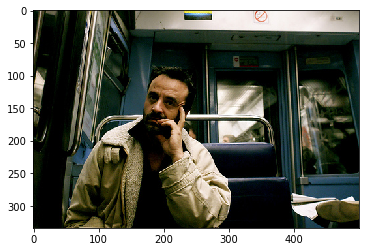

In [19]:
img_id = list(test_image_features.keys())[100]
print(greedySearch(test_image_features[img_id].reshape((1, 2048)), model))
x = plt.imread(f'{FLICKR8K_DATASET}/{img_id}.jpg')
plt.imshow(x)
plt.show()